**Lagasca DSM-to-Hybrid DSM-DTM Conversion Pipeline**

This notebook automates the pre-processing and conversion of a high-resolution DSMs into Hybrid DSM-DTMs for volcanic hazard modelling.  

The workflow includes:

1. **Environment & File Setup**
   - Mount Google Drive and configure project paths
   - Install and import required libraries

2. **DSM & Auxiliary Data Preparation**
   - Load DSM raster
   - Align orthoimagery and woodland shapefile
   - Create aligned binary masks (vegetation/artefacts)

3. **Raster Alignment & Validation**
   - Ensure all rasters (DSM, ortho, masks) share CRS, resolution, and extent

4. **Tiling for Deep Learning**
   - Tile DSM + RGB into 256×256 patches
   - Generate corresponding mask tiles
   - Visualize random tiles for QA

5. **Model Definition & Training**
   - Define lightweight U-Net segmentation model
   - Handle class imbalance with weighted BCE + Dice loss
   - Train with validation, IoU/Dice metrics, checkpoints, and early stopping

6. **Inference & Stitching**
   - Predict vegetation masks on all tiles
   - Stitch tile predictions back into a seamless raster
   - Align stitched mask to DSM grid

7. **DTM Reconstruction**
   - Remove vegetation/artefacts from DSM using masks
   - Interpolate terrain using safe filling strategies
   - Compute DSM–DTM difference rasters

8. **Post-Processing & Refinement**
   - Apply morphological filtering presets (balanced, aggressive, conservative)
   - Use vegetation booster (RGB + DSM indices) for robust detection
   - Build SAFE Hybrid DSM-DTMs with controlled interpolation

9. **Validation & QA**
   - Export difference maps and quick stats (coverage, volume removed)
   - Visualize results with hillshades and flow simulations

**Dataset:** Lagasca site UAV-derived DSM  
**Outputs:** Hybrid DSM-DTMs (GeoTIFF) and DSM–DTM difference maps suitable for hazard simulation


In [ ]:
"""
Mount Google Drive into the Colab environment
to access project data and save results.
"""

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
"""
Installing core libraries required for:
- Array manipulation (numpy, scipy, pandas)
- Raster I/O (rasterio, tifffile)
- Visualization (matplotlib, rich)
- Vector data handling (geopandas, shapely, fiona, pyproj, rtree)
- Image processing (scikit-image, pillow, albumentations)
- Machine learning (PyTorch, torchvision, segmentation-models-pytorch)
"""
!pip install numpy scipy pandas matplotlib tqdm \
             scikit-image scikit-learn \
             torch torchvision torchmetrics \
             segmentation-models-pytorch \
             albumentations==1.3.0 \
             rasterio geopandas shapely fiona pyproj rtree tifffile \
             pillow rich --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 43.2 MB/s eta 0:00:00


In [ ]:
"""
Import required libraries after installation.
These cover numerical processing, raster/vector handling,
image processing, and PyTorch for deep learning.
"""
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.features import rasterize
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.fill import fillnodata
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
from scipy.ndimage import binary_opening, binary_closing, binary_dilation, median_filter, gaussian_filter, label, uniform_filter
from skimage.util import view_as_blocks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import math
import time
from pathlib import Path
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader, random_split
import glob

In [ ]:
"""
Generate an aligned woodland mask raster from a shapefile.

Steps:
1. Define file paths:
   - Input woodland shapefile (vector polygons of tree canopy)
   - Reference DSM raster (for spatial alignment)
   - Output path for the aligned woodland mask (GeoTIFF)

2. Read the woodland shapefile into a GeoDataFrame.

3. Open the reference DSM raster to extract:
   - Metadata (dimensions, resolution, CRS, transform)
   - Shape of the raster (height, width)

4. Reproject the woodland shapefile to match the DSM CRS.

5. Rasterize the woodland polygons:
   - Assign pixel value 1 where woodland exists, 0 otherwise
   - Ensure rasterized mask matches DSM extent and resolution

6. Update metadata to ensure correct format for mask:
   - Set data type to uint8
   - Apply compression for efficient storage
   - Remove nodata field (not required for binary mask)

7. Write the aligned woodland mask to disk as a GeoTIFF.

Result: A raster mask (1 = woodland, 0 = background) perfectly aligned
with the reference DSM, ready for overlay and artefact removal.
"""

shapefile_path = "/content/drive/MyDrive/Project/Woodland.shp"
reference_raster_path = "/content/drive/MyDrive/Project/DEMGasca.tif"
output_mask_path = "/content/drive/MyDrive/Project/Woodland_mask_aligned.tif"

woodland_gdf = gpd.read_file(shapefile_path)

with rasterio.open(reference_raster_path) as ref_raster:
    out_meta = ref_raster.meta.copy()
    transform = ref_raster.transform
    out_shape = (ref_raster.height, ref_raster.width)
    crs = ref_raster.crs

    woodland_gdf = woodland_gdf.to_crs(crs)

    woodland_mask = rasterize(
        [(geom, 1) for geom in woodland_gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

out_meta.update({
    "count": 1,
    "dtype": 'uint8',
    "compress": 'lzw'
})
out_meta.pop("nodata", None)

with rasterio.open(output_mask_path, "w", **out_meta) as dest:
    dest.write(woodland_mask, 1)

print("Aligned woodland mask created.")

Aligned woodland mask created.


In [ ]:
"""
Align high-resolution orthoimage to match the reference DSM.

Steps:
1. Define file paths:
   - Input orthoimage (RGB aerial photograph)
   - Reference DSM (for alignment and spatial metadata)
   - Output path for aligned orthoimage

2. Open the reference DSM to extract:
   - Metadata (CRS, transform, resolution, shape)

3. Open the orthoimage:
   - Read all bands (typically 3 for RGB)
   - Get CRS of the orthoimage

4. Initialize an empty NumPy array with the same shape as the DSM.

5. Reproject each ortho band:
   - Source = original ortho band
   - Destination = aligned output band
   - Transform and CRS converted to match DSM
   - Resampling = bilinear (smooth interpolation for continuous imagery)

6. Update metadata:
   - Ensure correct number of bands
   - Use same data type as original ortho
   - Apply LZW compression
   - Remove nodata (not applicable to RGB images)

7. Save the aligned orthoimage as a GeoTIFF.

Result: An orthoimage perfectly downscaled and spatially aligned
with the DSM, ready for use in training and overlay analysis.
"""

ortho_in = "/content/drive/MyDrive/Project/OrtoGasca.tif"
dem_ref = "/content/drive/MyDrive/Project/DEMGasca.tif"
ortho_out = "/content/drive/MyDrive/Project/OrtoGasca_aligned.tif"

with rasterio.open(dem_ref) as ref:
    ref_meta = ref.meta.copy()
    ref_transform = ref.transform
    ref_shape = (ref.height, ref.width)
    ref_crs = ref.crs

with rasterio.open(ortho_in) as src:
    ortho_data = src.read()  # shape: (3, H, W)
    ortho_crs = src.crs

    aligned_ortho = np.empty((src.count, ref_shape[0], ref_shape[1]), dtype=src.dtypes[0])

    for i in range(src.count):
        reproject(
            source=ortho_data[i],
            destination=aligned_ortho[i],
            src_transform=src.transform,
            src_crs=ortho_crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            dst_shape=ref_shape,
            resampling=Resampling.bilinear
        )

ref_meta.update({
    "count": ortho_data.shape[0],
    "dtype": ortho_data.dtype,
    "compress": "lzw"
})
ref_meta.pop("nodata", None)

with rasterio.open(ortho_out, "w", **ref_meta) as dest:
    dest.write(aligned_ortho)

print("Ortho image downscaled and aligned.")

Ortho image downscaled and aligned.


In [ ]:
"""
Check spatial alignment between orthoimage, DSM, and woodland mask.

Steps:
1. Define file paths for:
   - Aligned orthoimage (RGB)
   - DSM raster
   - Woodland mask raster

2. Open all three rasters simultaneously using rasterio.

3. Perform consistency checks:
   - CRS: all layers must share the same coordinate reference system
   - Transform: pixel grid (origin, resolution, orientation) must match
   - Shape: width and height must be identical across rasters

4. Collect any mismatches into an error list.

5. Print results:
   - If errors exist → list which property mismatches
   - If no errors → confirm that all rasters are aligned

Result: Validation that ortho, DSM, and mask layers are
spatially consistent and safe to use together in further analysis.
"""

ortho_path = "/content/drive/MyDrive/Project/OrtoGasca_aligned.tif"
dem_path = "/content/drive/MyDrive/Project/DEMGasca.tif"
mask_path = "/content/drive/MyDrive/Project/Woodland_mask_aligned.tif"

with rasterio.open(ortho_path) as ortho, \
     rasterio.open(dem_path) as dem, \
     rasterio.open(mask_path) as mask:

    errors = []

    if not (ortho.crs == dem.crs == mask.crs):
        errors.append("CRS mismatch")

    if not (ortho.transform == dem.transform == mask.transform):
        errors.append("Transform mismatch")

    if not (ortho.width == dem.width == mask.width and ortho.height == dem.height == mask.height):
        errors.append("Shape mismatch")

    if errors:
        print("Alignment incorrect:")
        for e in errors:
            print(f"- {e}")
    else:
        print("All rasters aligned.")

All rasters aligned.


In [ ]:
"""
Tile orthoimage, DSM, and woodland mask into smaller patches for model training.

Steps:
1. Configuration:
   - tile_size = 256 px
   - stride = 256 (no overlap)
   - min_mask_pixels = 1 (skip tiles with no vegetation)

2. Define file paths:
   - Aligned orthoimage (RGB bands)
   - DSM raster
   - Woodland mask raster
   - Output directories for saving tiles

3. Read rasters:
   - Ortho (R, G, B bands only, float32)
   - DSM (single band, float32)
   - Mask (binary, uint8)

4. Preprocess DSM:
   - Replace nodata values (-32767) with 0

5. Validate shape consistency:
   - All three rasters must share identical dimensions

6. Sliding window tiling:
   - Iterate over raster in non-overlapping 256x256 windows
   - Extract RGB tile, DSM tile, and corresponding mask tile
   - Skip if mask tile is empty (no woodland pixels)

7. For first tile only, print debug info:
   - Min, max, dtype of DSM tile

8. Prepare training data:
   - Stack RGB + DSM into a 4-channel input tile
   - Keep mask as single-channel binary tile

9. Save results:
   - Input tiles → `/inputs` folder
   - Mask tiles  → `/masks` folder
   - Files stored as `.npy` arrays with consistent IDs

Result: A dataset of paired input (RGB + DSM) and mask tiles,
ready for deep learning model training.
"""

tile_size = 256
stride = 256
min_mask_pixels = 1

ortho_path = "/content/drive/MyDrive/Project/OrtoGasca_aligned.tif"
dem_path = "/content/drive/MyDrive/Project/DEMGasca.tif"
mask_path = "/content/drive/MyDrive/Project/Woodland_mask_aligned.tif"
output_root = "/content/drive/MyDrive/Project/Tiles"
input_dir = os.path.join(output_root, "inputs")
mask_dir = os.path.join(output_root, "masks")
os.makedirs(input_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

with rasterio.open(ortho_path) as ortho_src, \
     rasterio.open(dem_path) as dem_src, \
     rasterio.open(mask_path) as mask_src:

    rgb = ortho_src.read([1, 2, 3]).astype(np.float32)  # Only R, G, B
    dem = dem_src.read(1).astype(np.float32)            # shape: (H, W)
    mask = mask_src.read(1).astype(np.uint8)            # shape: (H, W)

    dsm = np.where(dsm == -32767.0, 0, dsm)

    assert rgb.shape[1:] == dem.shape == mask.shape, "Shape mismatch detected."

    H, W = dem.shape
    tile_id = 0

    print("Tiling started...")
    for i in tqdm(range(0, H - tile_size + 1, stride)):
        for j in range(0, W - tile_size + 1, stride):
            rgb_tile = rgb[:, i:i+tile_size, j:j+tile_size]
            dem_tile = dem[i:i+tile_size, j:j+tile_size]
            mask_tile = mask[i:i+tile_size, j:j+tile_size]

            if np.sum(mask_tile) < min_mask_pixels:
                continue

            if tile_id == 0:
                print("Tiling DSM debug:")
                print(" - min:", dem_tile.min())
                print(" - max:", dem_tile.max())
                print(" - dtype:", dem_tile.dtype)

            input_tile = np.concatenate([rgb_tile, dem_tile[np.newaxis, ...]], axis=0)
            mask_tile = mask_tile[np.newaxis, ...]  # (1, H, W)


            input_path = os.path.join(input_dir, f"tile_{tile_id:05d}.npy")
            mask_path_out = os.path.join(mask_dir, f"tile_{tile_id:05d}.npy")
            np.save(input_path, input_tile)
            np.save(mask_path_out, mask_tile)

            tile_id += 1

print(f"Tiling complete. {tile_id} tiles saved to:")
print(f"{input_dir} (inputs)")
print(f"{mask_dir} (masks)")


Tiling started...


  0%|          | 0/19 [00:00<?, ?it/s]

Tiling DSM debug:
 - min: 0.0
 - max: 2855.068
 - dtype: float32


100%|██████████| 19/19 [09:01<00:00, 28.50s/it]

Tiling complete. 306 tiles saved to:
/content/drive/MyDrive/Project/Tiles/inputs (inputs)
/content/drive/MyDrive/Project/Tiles/masks (masks)


In [ ]:
"""
Inspect maximum elevation value and data type of the DSM channel in a sample tile
Purpose:
This check helps verify that DSM values were preserved correctly during tiling,
and confirms expected data type consistency (float32 for elevation values).

"""
tile = np.load("/content/drive/MyDrive/Project/Tiles/inputs/tile_00000.npy")
print("DEM max:", tile[3].max(), "dtype:", tile[3].dtype)


DEM max: 2855.068 dtype: float32


In [ ]:
"""
Visualize random training tiles (RGB, DSM, and vegetation mask).

Steps:
1. Define input/output directories for tiles:
   - `inputs` → 4-channel tiles (RGB + DSM)
   - `masks`  → vegetation mask tiles

2. Collect all tile IDs from the input directory.

3. Randomly select 5 tiles for inspection.

4. For each selected tile:
   - Load the 4-channel input (RGB + DSM)
   - Load the corresponding vegetation mask
   - Extract RGB (channels 0–2) and transpose to (H, W, 3)
   - Extract DSM (channel 3)

5. Plot 3 subplots side-by-side:
   - Orthoimage (RGB)
   - DSM elevation map (terrain colormap with colorbar)
   - Orthoimage overlaid with vegetation mask

Purpose:
This visualization validates that RGB, DSM, and mask tiles
are correctly aligned, and provides a quick quality check
on tiling results before training the model.
"""

input_dir = "/content/drive/MyDrive/Project/Tiles/inputs"
mask_dir = "/content/drive/MyDrive/Project/Tiles/masks"

tile_ids = sorted([
    int(f.split("_")[1].split(".")[0])
    for f in os.listdir(input_dir)
    if f.endswith(".npy")
])

samples = random.sample(tile_ids, 5)

for tile_id in samples:
    input_path = os.path.join(input_dir, f"tile_{tile_id:05d}.npy")
    mask_path = os.path.join(mask_dir, f"tile_{tile_id:05d}.npy")

    input_tile = np.load(input_path)
    mask_tile = np.load(mask_path)[0]

    rgb = input_tile[:3].transpose(1, 2, 0)
    dem = input_tile[3]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(rgb.astype(np.uint8))
    axs[0].set_title(f"Ortho-imagery (Tile {tile_id})")
    axs[0].axis("off")

    dem_plot = axs[1].imshow(dem, cmap="terrain")
    axs[1].set_title("DEM (elevation)")
    axs[1].axis("off")
    fig.colorbar(dem_plot, ax=axs[1], shrink=0.7)

    axs[2].imshow(rgb.astype(np.uint8))
    axs[2].imshow(mask_tile, cmap="Reds", alpha=0.5)
    axs[2].set_title("Vegetation Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
Define global configurations, file paths, and training parameters
for the DSM-to-Hybrid DSM-DTM pipeline.

Steps:
1. Set directory paths:
   - INPUT_TILES_DIR: 4-channel tiles (RGB + DSM)
   - MASK_TILES_DIR:  vegetation mask tiles
   - PRED_TILES_DIR:  directory for storing model predictions
   - ORIG_DEM_TIF:    original DSM file
   - OUT_DIR:         root outputs directory
   - CHECKPOINT_DIR:  for saving trained model checkpoints
   - SAMPLE_PLOTS_DIR: preview plots during training
   - STITCHED_PRED_TIF: stitched prediction raster
   - DTM_TIF:          final generated DTM
   - DIFF_TIF / DIFF_PNG: DSM–DTM difference maps

2. Define training hyperparameters:
   - Random seed for reproducibility
   - Input/output channels (4 for RGB+DSM, 1 for mask)
   - Tile size and stride
   - Batch size
   - Learning rate, weight decay, gradient clipping norm
   - Number of epochs
   - Validation split fraction
   - Visualization frequency (every N epochs)

3. Ensure required directories exist, creating them if necessary.

4. Set random seeds across Python, NumPy, and PyTorch to guarantee
   reproducibility.

5. Define training device:
   - Use CUDA GPU if available
   - Otherwise fall back to CPU

Purpose:
This cell centralizes all core parameters and directory structures,
ensuring reproducibility and a consistent workflow for model training
and evaluation.
"""

INPUT_TILES_DIR = "/content/drive/MyDrive/Project/Tiles/inputs"
MASK_TILES_DIR  = "/content/drive/MyDrive/Project/Tiles/masks"
PRED_TILES_DIR  = "/content/drive/MyDrive/Project/Tiles/preds"
ORIG_DEM_TIF    = "/content/drive/MyDrive/Project/DEMGasca.tif"
OUT_DIR         = "/content/drive/MyDrive/Project/Outputs"
CHECKPOINT_DIR  = "/content/drive/MyDrive/Project/checkpoints"
SAMPLE_PLOTS_DIR= f"{OUT_DIR}/train_previews"

STITCHED_PRED_TIF = f"{OUT_DIR}/Lagasca_pred_mask.tif"
DTM_TIF           = f"{OUT_DIR}/Lagasca_DTM.tif"
DIFF_TIF          = f"{OUT_DIR}/Lagasca_DEM_minus_DTM.tif"
DIFF_PNG          = f"{OUT_DIR}/Lagasca_DEM_minus_DTM.png"

# Training parameters
SEED          = 1234
IN_CHANNELS   = 4
OUT_CHANNELS  = 1
TILE_SIZE     = 256
STRIDE        = 256
BATCH_SIZE    = 8
LR            = 1e-3
WEIGHT_DECAY  = 1e-4
EPOCHS        = 100
GRAD_CLIP_NORM= 1.0
VAL_SPLIT     = 0.2
VISUAL_EVERY  = 2

for d in [OUT_DIR, CHECKPOINT_DIR, SAMPLE_PLOTS_DIR, PRED_TILES_DIR]:
    os.makedirs(d, exist_ok=True)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""
Utility functions for preprocessing and visualizing training samples.

Functions:
1. normalize_rgb(rgb):
   - Input: RGB tile [3, H, W]
   - Scales values to [0,1] range
   - If max > 1.0, assumes input in [0,255] and divides by 255
   - Ensures consistent float32 output for model input

2. normalize_dem(dem):
   - Input: DEM tile [H, W]
   - Uses 2nd and 98th percentiles for robust normalization
   - Clips DEM values within this range
   - Scales to [0,1] range
   - Handles edge cases where DEM is nearly flat (returns zeros)

3. show_samples(rgb, dem, gt, pred=None, title=""):
   - Visualization helper for inspecting tiles
   - Plots side-by-side:
       * RGB orthoimage
       * Scaled DEM
       * Ground truth mask
       * (Optional) Predicted mask
   - Useful for debugging preprocessing and monitoring training results

Purpose:
These helper functions standardize inputs (RGB + DEM)
before training, and provide quick visual diagnostics of
ground truth and model predictions.
"""

def normalize_rgb(rgb):
    # rgb: [3,H,W]
    m = rgb.max()
    if m > 1.0: rgb = rgb / 255.0
    return np.clip(rgb, 0.0, 1.0).astype(np.float32)

def normalize_dem(dem):
    # robust per-tile [0,1]
    p2, p98 = np.percentile(dem, (2, 98))
    if p98 - p2 < 1e-6:
        return np.zeros_like(dem, dtype=np.float32)
    d = np.clip(dem, p2, p98)
    d = (d - p2) / (p98 - p2 + 1e-6)
    return d.astype(np.float32)

def show_samples(rgb, dem, gt, pred=None, title=""):
    cols = 4 if pred is not None else 3
    plt.figure(figsize=(4*cols, 4))
    plt.subplot(1, cols, 1); plt.imshow(np.moveaxis(rgb,0,2)); plt.title("RGB"); plt.axis("off")
    plt.subplot(1, cols, 2); plt.imshow(dem); plt.title("DEM (scaled)"); plt.axis("off")
    plt.subplot(1, cols, 3); plt.imshow(gt, cmap="gray"); plt.title("GT mask"); plt.axis("off")
    if pred is not None:
        plt.subplot(1, cols, 4); plt.imshow(pred, cmap="gray"); plt.title("Pred mask"); plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

In [ ]:
"""
Custom PyTorch Dataset for loading tiled inputs (RGB + DEM)
and corresponding vegetation masks.

Class: TilesDatasetMasked

1. __init__(x_dir, y_dir, augment=False):
   - x_dir: directory of input tiles (.npy), each [4,H,W] (RGB + DEM)
   - y_dir: directory of mask tiles (.npy), each [1,H,W] or [H,W]
   - augment: boolean flag to enable random data augmentations
   - Collects and sorts all .npy files from x_dir
   - Raises error if no tiles are found

2. __len__():
   - Returns number of available tiles

3. __getitem__(idx):
   - Loads input tile [4,H,W]
   - Splits into:
       * RGB channels (0–2), normalized to [0,1]
       * DEM channel (3), robustly normalized [0,1]
   - Loads corresponding mask:
       * Matches file name
       * Ensures binary format (1 = vegetation, 0 = background)
   - Generates valid mask:
       * Marks pixels where RGB > 0 and DEM is finite
   - Optional augmentations (random flips, rotations):
       * Horizontal flip
       * Vertical flip
       * 90° rotation
   - Reconstructs normalized input tile [4,H,W]
   - Returns tuple:
       (input tensor, mask tensor [1,H,W], valid tensor [1,H,W])

Dataset usage:
- Provides standardized inputs for training segmentation models
- Ensures masks and valid pixels align with inputs
- Supports optional simple augmentations for robustness

Example:
    full_ds = TilesDatasetMasked(INPUT_TILES_DIR, MASK_TILES_DIR, augment=False)
"""

class TilesDatasetMasked(Dataset):
    def __init__(self, x_dir, y_dir, augment=False):
        self.x_dir = x_dir; self.y_dir = y_dir
        self.files = natsorted([f for f in os.listdir(x_dir) if f.endswith(".npy")])
        if len(self.files) == 0:
            raise RuntimeError(f"No .npy tiles in {x_dir}")
        self.augment = augment

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        x = np.load(os.path.join(self.x_dir, name))  # [4,H,W]
        if x.ndim != 3 or x.shape[0] != IN_CHANNELS:
            raise RuntimeError(f"Input {name} expected [4,H,W], got {x.shape}")

        rgb = normalize_rgb(x[:3].astype(np.float32))
        dem = normalize_dem(x[3].astype(np.float32))

        mpath = os.path.join(self.y_dir, name)
        if not os.path.exists(mpath):
            base = os.path.splitext(name)[0]
            mpath = os.path.join(self.y_dir, f"{base}.npy")
        y = np.load(mpath)
        if y.ndim == 3: y = y[0]
        y = (y > 0).astype(np.float32)

        valid = ((rgb.sum(axis=0) > 0) & np.isfinite(dem)).astype(np.float32)

        if self.augment:
            r = random.random()
            if r < 0.25:
                rgb = rgb[:, :, ::-1]; dem = dem[:, ::-1]; y = y[:, ::-1]; valid = valid[:, ::-1]
            elif r < 0.5:
                rgb = rgb[:, ::-1, :]; dem = dem[::-1, :]; y = y[::-1, :]; valid = valid[::-1, :]
            elif r < 0.75:
                rgb = np.rot90(rgb, 1, axes=(1,2)); dem = np.rot90(dsm, 1); y = np.rot90(y, 1); valid = np.rot90(valid, 1)

        x_norm = np.concatenate([rgb, dem[None, ...]], axis=0)  # [4,H,W]
        return (torch.from_numpy(x_norm),
                torch.from_numpy(y[None, ...]),                 # [1,H,W]
                torch.from_numpy(valid[None, ...]))             # [1,H,W]

full_ds = TilesDatasetMasked(INPUT_TILES_DIR, MASK_TILES_DIR, augment=False)


In [ ]:
"""
Compute class imbalance weighting for Binary Cross-Entropy (BCE) loss.

Function: compute_pos_weight(ds, sample_k=500)

1. Parameters:
   - ds: dataset object (TilesDatasetMasked)
   - sample_k: number of samples to estimate statistics (default = 500)

2. Sampling:
   - Select up to sample_k evenly spaced tiles from dataset
   - For each tile:
       * Extract mask (y) and valid pixels (v)
       * Multiply y * v to keep only valid vegetation pixels
       * Count positive pixels (vegetation) and total pixels

3. Aggregation:
   - Accumulate positive and total pixel counts across sampled tiles
   - Compute negative pixels = total - positive
   - Avoid division by zero by enforcing minimum values

4. Return:
   - pos_weight = (negative / positive)
   - Torch tensor (float32) for use in BCEWithLogitsLoss

5. Usage:
   - Balances BCE loss when vegetation pixels are sparse compared to background
   - Larger pos_weight emphasizes minority vegetation class during training

Result:
Provides a data-driven weighting factor to handle
class imbalance in segmentation training.
"""

def compute_pos_weight(ds, sample_k=500):
    n = min(len(ds), sample_k)
    idxs = np.linspace(0, len(ds)-1, n).astype(int)
    pos = 0.0; tot = 0.0
    for i in idxs:
        _, y, v = ds[i]
        y = (y * v)[0].numpy()
        pos += y.sum(); tot += y.size
    neg = max(tot - pos, 1.0); pos = max(pos, 1.0)
    import torch
    return torch.tensor(neg/pos, dtype=torch.float32)

pos_weight = compute_pos_weight(full_ds)
print(f"Estimated pos_weight for BCE: {pos_weight.item():.2f}")


Estimated pos_weight for BCE: 13.04


In [ ]:
"""
Split dataset into training and validation sets, and create DataLoaders.

Steps:
1. Compute dataset sizes:
   - val_len = fraction of total dataset defined by VAL_SPLIT
   - train_len = remaining samples

2. Perform split using torch.utils.data.random_split:
   - Ensures reproducibility by setting manual seed

3. Apply augmentations:
   - Training dataset → augment=True (random flips/rotations enabled)
   - Validation dataset → augment=False (clean, deterministic samples)

4. Create DataLoaders:
   - train_dl:
       * batch_size = BATCH_SIZE
       * shuffle=True for randomness in training
       * drop_last=True to ensure consistent batch sizes
   - val_dl:
       * batch_size = BATCH_SIZE
       * shuffle=False (deterministic order for evaluation)
       * drop_last not needed

Purpose:
- Ensures robust training by reserving part of the data for validation
- Uses augmentations only on training data to improve generalization
- Wraps datasets in DataLoaders for efficient minibatch iteration
  during training and validation.
"""

val_len = int(len(full_ds) * VAL_SPLIT)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(SEED))
train_ds.dataset.augment = True
val_ds.dataset.augment = False

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



In [ ]:
"""
Define a lightweight U-Net segmentation model for DSM-to-Hybrid DSM-DTM processing.

Components:
1. ConvBlock (nn.Module):
   - Two consecutive convolutional layers with 3x3 kernels
   - Each followed by BatchNorm and ReLU activation
   - Encapsulated in a reusable block for encoder/decoder

2. UNetLite (nn.Module):
   - Encoder (downs):
       * Sequence of ConvBlocks with increasing feature sizes (32, 64, 128, 256)
       * MaxPooling after each block to downsample feature maps
       * Stores skip connections for later concatenation
   - Bottleneck:
       * Deepest ConvBlock with doubled feature size
   - Decoder (ups):
       * Uses ConvTranspose2d for upsampling
       * Concatenates skip connections from encoder
       * Follows with ConvBlock to refine features
       * Padding applied if feature maps differ slightly in size
   - Final layer:
       * 1x1 convolution to reduce channels to output mask (1 for binary segmentation)

3. Model instantiation:
   - Input channels = 4 (RGB + DSM)
   - Output channels = 1 (vegetation mask)
   - Deployed on GPU if available, otherwise CPU

Purpose:
This lightweight U-Net captures multi-scale spatial features
of the DSM and orthoimage, enabling semantic segmentation
to detect and remove vegetation/artefacts in DSM-to-Hybrid DSM-DTM conversion.
"""

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class UNetLite(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[32,64,128,256]):
        super().__init__()
        self.downs = nn.ModuleList(); self.ups = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2,2)
        ch = in_channels
        for f in features:
            self.downs.append(ConvBlock(ch, f)); ch = f
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, 2, 2))
            self.ups.append(ConvBlock(f*2, f))
        self.final = nn.Conv2d(features[0], out_channels, 1)
    def forward(self, x):
        skips = []
        for d in self.downs:
            x = d(x); skips.append(x); x = self.pool(x)
        x = self.bottleneck(x); skips = skips[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            s = skips[i//2]
            if x.shape[-2:] != s.shape[-2:]:
                diffY = s.size(2) - x.size(2); diffX = s.size(3) - x.size(3)
                x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
            x = torch.cat([s, x], dim=1)
            x = self.ups[i+1](x)
        return self.final(x)

model = UNetLite(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(DEVICE)


In [ ]:
"""
Define custom loss functions, training hyperparameters, and optimizer setup.

1. Global parameters:
   - EPS: small constant to avoid division by zero
   - ALPHA: balance between BCE and Dice losses (default 0.5)
   - PRED_THRESH: sigmoid threshold for converting logits to binary mask

2. Loss functions:
   a. bce_with_logits_masked:
      - Binary Cross-Entropy loss computed only over valid pixels
      - Supports dynamic pos_weight (computed per-batch from class balance)
      - Optionally uses fixed pos_weight if provided
      - Helps counter severe foreground-background imbalance
   b. dice_loss_with_logits:
      - Soft Dice loss using sigmoid probabilities
      - Measures overlap between predicted mask and ground truth
      - Computed only on valid pixels
   c. total_loss_fn:
      - Weighted combination of BCE and Dice
      - alpha * BCE + (1 - alpha) * Dice
      - Default alpha = 0.5 (equal balance)

3. Scheduler helper:
   - step_scheduler:
      * Wraps ReduceLROnPlateau
      * Monitors validation loss
      * Reduces learning rate if validation loss plateaus
      * Prints change for transparency

4. Optimizer and scheduler:
   - AdamW optimizer with learning rate = LR and weight decay = WEIGHT_DECAY
   - ReduceLROnPlateau scheduler:
       * Reduces LR by factor of 0.5 if validation loss does not improve
       * Patience = 2 epochs

Purpose:
This setup combines BCE (pixel-level classification) with Dice (region overlap)
to balance precision and recall in vegetation segmentation, while adaptive
learning rate scheduling helps stabilize and accelerate training.
"""

import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPS = 1e-6
ALPHA = 0.5
PRED_THRESH = 0.70

def bce_with_logits_masked(logits, targets, valid_mask, dynamic_pos_weight=True, fixed_pos_weight=None):
    targets = targets.float()
    valid_mask = valid_mask.float()

    if dynamic_pos_weight:
        pos = (targets * valid_mask).sum()
        neg = ((1.0 - targets) * valid_mask).sum()
        pw = (neg / (pos + EPS)).clamp(max=100.0).detach()
        pos_weight = torch.as_tensor(pw, device=logits.device, dtype=logits.dtype)
    elif fixed_pos_weight is not None:
        pos_weight = torch.as_tensor(fixed_pos_weight, device=logits.device, dtype=logits.dtype)
    else:
        pos_weight = None

    bce = F.binary_cross_entropy_with_logits(
        logits, targets, reduction='none', pos_weight=pos_weight
    )
    bce = (bce * valid_mask).sum() / (valid_mask.sum() + EPS)
    return bce

def dice_loss_with_logits(logits, targets, valid_mask, eps=EPS):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    valid_mask = valid_mask.float()

    inter = (probs * targets * valid_mask).sum(dim=(1,2,3))
    den   = (probs * valid_mask).sum(dim=(1,2,3)) + (targets * valid_mask).sum(dim=(1,2,3))
    dice  = (2.0 * inter + eps) / (den + eps)
    return 1.0 - dice.mean()

def total_loss_fn(logits, targets, valid_mask, alpha=ALPHA):
    bce = bce_with_logits_masked(logits, targets, valid_mask, dynamic_pos_weight=True)
    dl  = dice_loss_with_logits(logits, targets, valid_mask)
    return alpha * bce + (1.0 - alpha) * dl

def step_scheduler(scheduler, optimizer, val_loss, announce=True):
    old_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]["lr"]
    if announce and new_lr < old_lr:
        print(f"Learning rate reduced: {old_lr:.6g} → {new_lr:.6g}")


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

In [ ]:
"""
Define evaluation metrics for segmentation performance.

1. iou_score(pred, target, eps=1e-6):
   - Computes Intersection-over-Union (IoU), also known as the Jaccard Index
   - Formula: IoU = Intersection / Union
   - Intersection = overlapping positive pixels between prediction and target
   - Union = total positive pixels across prediction and target
   - Averaged across the batch
   - eps prevents division by zero

2. dice_score(pred, target, eps=1e-6):
   - Computes Dice Similarity Coefficient (DSC), also known as F1-score in segmentation
   - Formula: Dice = (2 * Intersection) / (Sum of prediction and target positives)
   - Measures spatial overlap between predicted mask and ground truth
   - Averaged across the batch
   - eps prevents division by zero

Purpose:
These metrics quantify how well predicted vegetation masks
match the ground truth:
- IoU emphasizes the strict overlap relative to union
- Dice emphasizes overlap relative to the average size of regions
"""

def iou_score(pred, target, eps=1e-6):
    inter = (pred*target).sum(dim=(1,2,3))
    union = (pred+target - pred*target).sum(dim=(1,2,3)) + eps
    return (inter / union).mean().item()

def dice_score(pred, target, eps=1e-6):
    inter = (pred*target).sum(dim=(1,2,3))
    den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return (2*inter / den).mean().item()


In [ ]:
"""
Full training loop for U-Net Lite with validation, visualization, and checkpointing.

1. Preview function (render_val_samples):
   - Runs model in evaluation mode on validation samples
   - Computes predictions using sigmoid + threshold
   - Displays side-by-side:
       * RGB orthoimage
       * DEM (scaled)
       * Ground truth vegetation mask
       * Predicted vegetation mask
   - Saves preview image to SAMPLE_PLOTS_DIR
   - Called every VISUAL_EVERY epochs for qualitative monitoring

2. Training setup:
   - Initialize best_val (best validation loss) and early stopping counters
   - Define patience (stop if no improvement for N epochs)

3. Epoch loop:
   a. Training phase:
      - Set model to train mode
      - Iterate through training DataLoader
      - Forward pass → compute loss using total_loss_fn
      - Backward pass → gradient clipping for stability
      - Optimizer step
      - Accumulate average training loss

   b. Validation phase:
      - Set model to eval mode
      - Iterate through validation DataLoader (no gradients)
      - Compute validation loss
      - Generate predictions (sigmoid + threshold)
      - Compute IoU and Dice metrics
      - Step learning rate scheduler with val_loss

   c. Logging:
      - Print metrics: epoch, train_loss, val_loss, IoU, Dice

   d. Visualization:
      - Every VISUAL_EVERY epochs, call render_val_samples

   e. Checkpointing:
      - If validation loss improves, save model state_dict
      - Track best epoch and reset early stopping counter
      - If no improvement for `patience` epochs, trigger early stopping

4. Completion:
   - Print best epoch and corresponding validation loss

Purpose:
This training loop integrates robust monitoring:
- Quantitative (loss, IoU, Dice)
- Qualitative (visual previews)
- Stability mechanisms (gradient clipping, LR scheduling, early stopping)
- Model checkpointing for best epoch

Ensures efficient and reliable training of U-Net Lite
for DSM artefact removal and vegetation segmentation.
"""

MODEL_BEST_PATH = os.path.join(CHECKPOINT_DIR, "unetlite_best_state_dict.pth")

def render_val_samples(epoch, max_batches=1):
    model.eval()
    shown = 0
    with torch.no_grad():
        for xb, yb, vb in val_dl:
            xb, yb, vb = xb.to(DEVICE).float(), yb.to(DEVICE).float(), vb.to(DEVICE).float()
            logits = model(xb)
            probs  = torch.sigmoid(logits)
            preds  = (probs > PRED_THRESH).float() * vb
            x0 = xb[0].cpu().numpy(); y0 = (yb[0,0]*vb[0,0]).cpu().numpy()
            p0 = preds[0,0].cpu().numpy()
            rgb = x0[:3]; dsm = x0[3]
            plt.figure(figsize=(12,3.5))
            plt.subplot(1,4,1); plt.imshow(np.moveaxis(rgb,0,2)); plt.title("RGB"); plt.axis("off")
            plt.subplot(1,4,2); plt.imshow(dem); plt.title("DEM (scaled)"); plt.axis("off")
            plt.subplot(1,4,3); plt.imshow(y0, cmap="gray"); plt.title("GT (valid)"); plt.axis("off")
            plt.subplot(1,4,4); plt.imshow(p0, cmap="gray"); plt.title("Pred (masked)"); plt.axis("off")
            plt.suptitle(f"Epoch {epoch} — Val sample")
            plt.tight_layout()
            out_png = os.path.join(SAMPLE_PLOTS_DIR, f"epoch_{epoch:03d}_preview.png")
            plt.savefig(out_png, dpi=160); plt.show()
            print("Saved preview:", out_png)
            shown += 1
            if shown >= max_batches: break

best_val = float("inf"); best_epoch = -1
patience, waited = 10, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for xb, yb, vb in train_dl:
        xb, yb, vb = xb.to(DEVICE).float(), yb.to(DEVICE).float(), vb.to(DEVICE).float()
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = total_loss_fn(logits, yb, vb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_dl.dataset)

    # val
    model.eval()
    val_loss = 0.0; iou = 0.0; dsc = 0.0
    with torch.no_grad():
        for xb, yb, vb in val_dl:
            xb, yb, vb = xb.to(DEVICE).float(), yb.to(DEVICE).float(), vb.to(DEVICE).float()
            logits = model(xb)
            vloss  = total_loss_fn(logits, yb, vb)
            val_loss += vloss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > PRED_THRESH).float() * vb
            iou  += iou_score(preds, yb*vb)
            dsc  += dice_score(preds, yb*vb)
    val_loss /= len(val_dl.dataset); iou /= max(1,len(val_dl)); dsc /= max(1,len(val_dl))
    step_scheduler(scheduler, optimizer, val_loss)

    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | IoU {iou:.3f} | Dice {dsc:.3f}")

    if epoch % VISUAL_EVERY == 0: render_val_samples(epoch, max_batches=1)

    if val_loss < best_val - 1e-5:
        best_val, best_epoch = val_loss, epoch
        torch.save(model.state_dict(), MODEL_BEST_PATH)
        print(f"New best at epoch {epoch}. Saved: {MODEL_BEST_PATH}")
        waited = 0
    else:
        waited += 1
        if waited >= patience:
            print(f"Early stopping at epoch {epoch} (best {best_epoch})")
            break

print("Training completed. Best epoch:", best_epoch, "Best val_loss:", round(best_val,4))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
Evaluate segmentation IoU across multiple thresholds to select the best value.

1. Function: eval_iou_at_thr(model, dataloader, thr=0.5)
   - Sets model to evaluation mode
   - Iterates over dataloader without gradient computation
   - Forward pass → logits → sigmoid probabilities
   - Converts probabilities to binary predictions using given threshold
   - Applies valid pixel mask (vb)
   - Accumulates:
       * Intersection = predicted positives ∩ ground truth
       * Union = predicted positives ∪ ground truth
   - Returns mean IoU at this threshold

2. Model loading:
   - Loads best checkpoint (saved during training) into model

3. Threshold search:
   - Defines a grid of thresholds between 0.3 and 0.7
   - For each threshold, compute IoU on validation set
   - Print IoU results for monitoring
   - Track threshold with highest IoU

4. Output:
   - Prints best threshold (BEST_THR) and corresponding IoU (BEST_IOU)

Purpose:
Instead of using a fixed threshold (e.g., 0.5),
this step tunes the prediction threshold based on validation IoU.
Improves segmentation performance, especially in cases
of class imbalance or fuzzy boundaries.
"""

def eval_iou_at_thr(model, dataloader, thr=0.5):
    model.eval()
    inter = 0.0; union = 0.0
    with torch.no_grad():
        for xb, yb, vb in dataloader:
            xb, yb, vb = xb.to(DEVICE).float(), yb.to(DEVICE).float(), vb.to(DEVICE).float()
            logits = model(xb)
            probs  = torch.sigmoid(logits)
            preds  = (probs > thr).float() * vb
            inter += (preds*(yb*vb)).sum().item()
            union += (preds + (yb*vb) - preds*(yb*vb)).sum().item()
    return inter / (union + 1e-6)

model.load_state_dict(torch.load(MODEL_BEST_PATH, map_location=DEVICE))
grid = np.linspace(0.3, 0.7, 9)
BEST_THR, BEST_IOU = 0.5, -1
for t in grid:
    iou_t = eval_iou_at_thr(model, val_dl, thr=float(t))
    print(f"thr={t:.2f} -> IoU={iou_t:.4f}")
    if iou_t > BEST_IOU:
        BEST_IOU, BEST_THR = iou_t, float(t)
print(f"Best threshold on val: {BEST_THR:.2f} (IoU={BEST_IOU:.4f})")


thr=0.30 -> IoU=0.4626
thr=0.35 -> IoU=0.4713
thr=0.40 -> IoU=0.4793
thr=0.45 -> IoU=0.4868
thr=0.50 -> IoU=0.4939
thr=0.55 -> IoU=0.5011
thr=0.60 -> IoU=0.5082
thr=0.65 -> IoU=0.5151
thr=0.70 -> IoU=0.5224
Best threshold on val: 0.70 (IoU=0.5224)


In [ ]:
"""
Convert probability map to a cleaned binary mask with coverage-based threshold adjustment.

Function: binarize_with_coverage_guard

Inputs:
- probs: [H,W] float array with probabilities in [0,1]
- valid: [H,W] binary mask of valid pixels (default = all valid)
- low_cov: minimum acceptable coverage fraction (default = 0.001 = 0.1%)
- high_cov: maximum acceptable coverage fraction (default = 0.65 = 65%)
- base_thr: default probability threshold (default = 0.5)

Steps:
1. If no valid pixels exist:
   - Fallback to simple thresholding at base_thr

2. Default prediction:
   - Convert probs > base_thr → binary mask

3. Compute coverage:
   - Fraction of predicted positive pixels within valid mask

4. Adaptive thresholding:
   - If coverage too low (< low_cov):
       * Increase sensitivity by lowering threshold
       * Use 95th percentile of probs as adjusted threshold
   - If coverage too high (> high_cov):
       * Decrease sensitivity by raising threshold
       * Use 5th percentile of probs as adjusted threshold

5. Morphological post-processing:
   - Apply binary opening (remove small noise)
   - Apply binary closing (fill small holes)

6. Apply valid mask to final result.

Output:
- Clean binary mask [H,W], aligned with valid pixels

Purpose:
Prevents pathological predictions where the model
outputs too few or too many positives.
Ensures realistic vegetation coverage ratios and
removes noise using morphological cleanup.
"""

from scipy.ndimage import binary_opening, binary_closing

def binarize_with_coverage_guard(probs, low_cov=0.001, high_cov=0.65, base_thr=0.5, valid=None):
    if valid is None:
        valid = np.ones_like(probs, dtype=np.uint8)
    p = probs[valid.astype(bool)]
    if p.size == 0:
        return (probs > base_thr).astype(np.uint8)
    pred = (probs > base_thr).astype(np.uint8)
    cov = (pred[valid.astype(bool)]).mean()
    if cov < low_cov:
        thr = np.percentile(p, 95)
        pred = (probs > min(thr, base_thr)).astype(np.uint8)
    elif cov > high_cov:
        thr = np.percentile(p, 5)
        pred = (probs > max(thr, base_thr)).astype(np.uint8)
    pred = binary_opening(pred, iterations=1).astype(np.uint8)
    pred = binary_closing(pred, iterations=1).astype(np.uint8)
    return (pred * valid).astype(np.uint8)

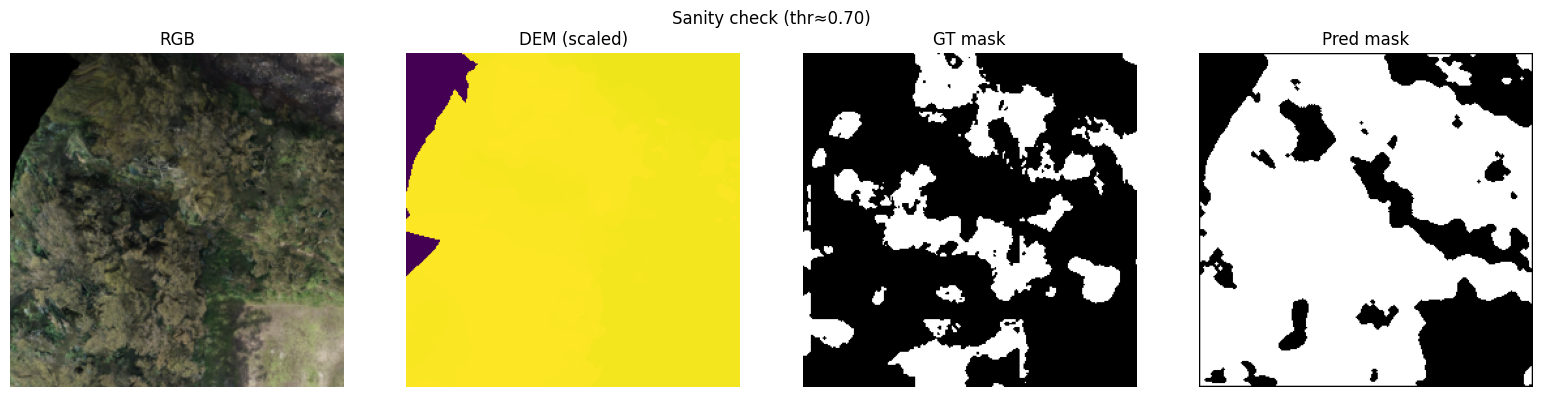

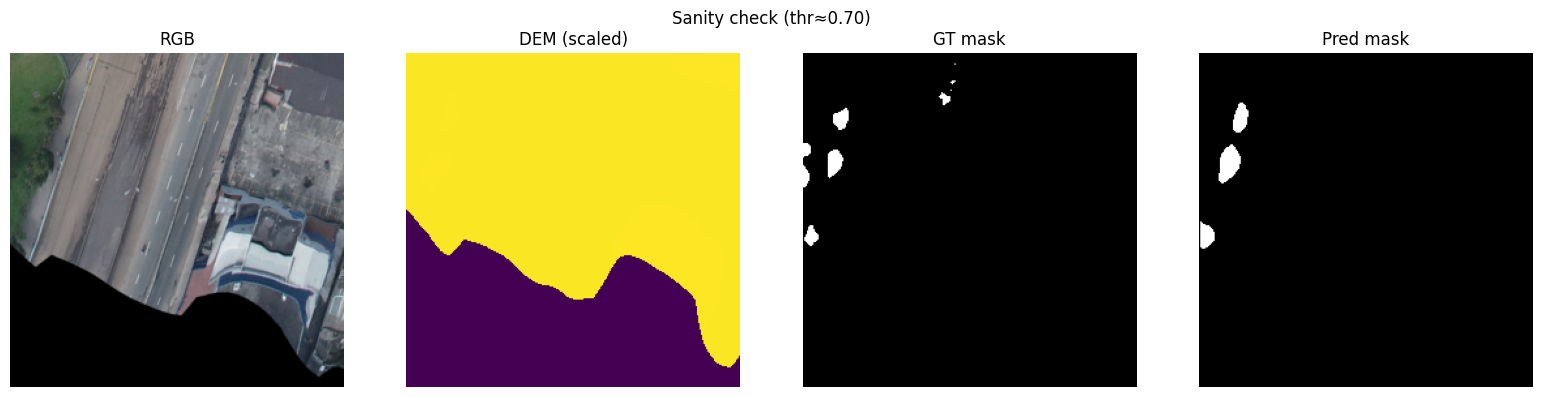

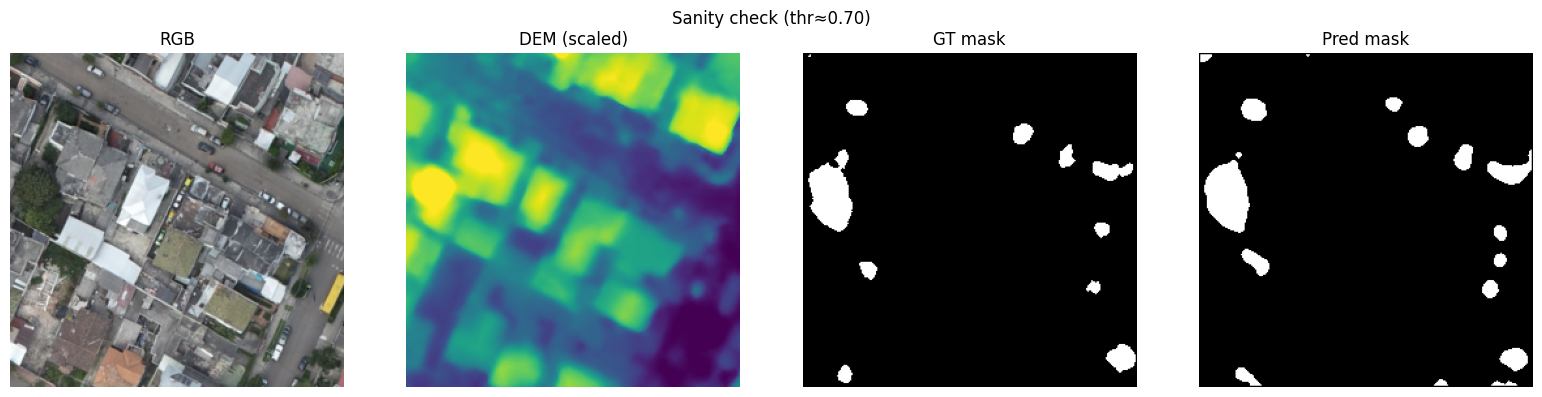

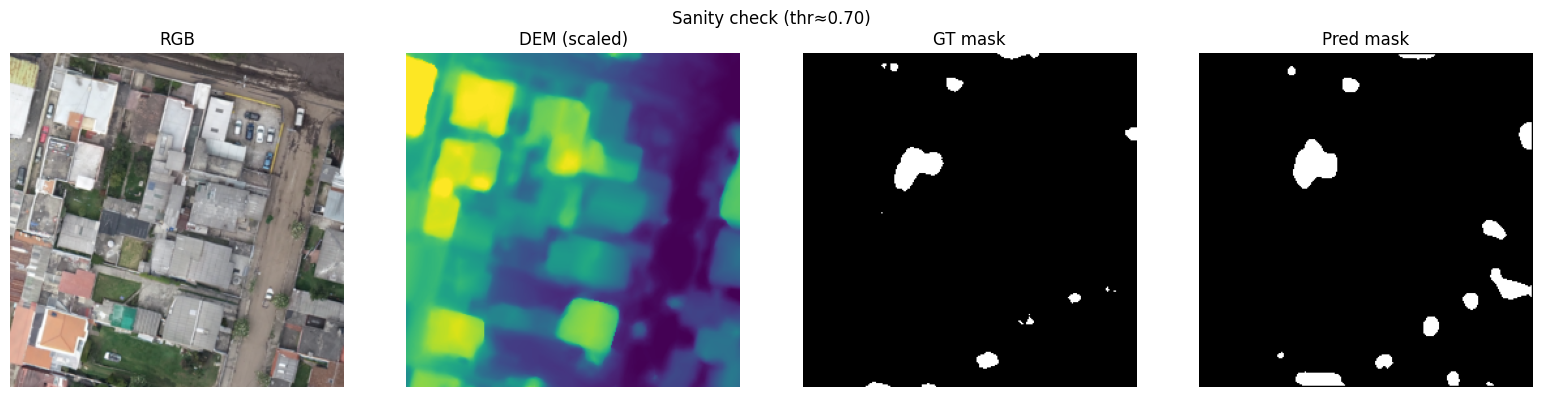

In [ ]:
"""
Visualize random samples from the dataset with model predictions
to perform a sanity check after training.

Function: visualize_random_samples(k=4, base_thr=None)

1. Parameters:
   - k: number of random samples to display (default = 4)
   - base_thr: threshold for binarization (default = BEST_THR found earlier)

2. Workflow:
   - Randomly select k indices from the full dataset
   - For each sample:
       * Load input (RGB+DEM), ground truth mask, and valid pixels
       * Run forward pass through model (eval mode, no gradients)
       * Apply sigmoid to logits → probability map
       * Binarize probabilities using binarize_with_coverage_guard:
           - Uses adaptive thresholding to avoid too high/low coverage
           - Cleans mask with morphological opening/closing
       * Extract RGB, DEM, ground truth, and predicted mask
       * Visualize using show_samples utility:
           - RGB orthoimage
           - DEM
           - Ground truth mask
           - Predicted mask overlay

3. Purpose:
   - Provides a qualitative sanity check on trained model
   - Ensures predictions look reasonable on random dataset samples
   - Confirms that thresholding and coverage guard behave as expected
"""

def visualize_random_samples(k=4, base_thr=None):
    if base_thr is None: base_thr = BEST_THR
    idxs = np.random.choice(len(full_ds), size=min(k, len(full_ds)), replace=False)
    model.eval()
    with torch.no_grad():
        for i in idxs:
            x, y, v = full_ds[i]
            xb = x.unsqueeze(0).to(DEVICE).float()
            logits = model(xb)
            probs  = torch.sigmoid(logits)[0,0].cpu().numpy()
            valid  = v[0].numpy()
            pred   = binarize_with_coverage_guard(probs, base_thr=base_thr, valid=valid)
            rgb, dem, gt = x[:3].numpy(), x[3].numpy(), (y[0]*v[0]).numpy()
            show_samples(rgb, dem, gt, pred, title=f"Sanity check (thr≈{base_thr:.2f})")

visualize_random_samples(k=4, base_thr=BEST_THR)


In [ ]:
"""
Run trained model on all input tiles and save predicted masks.

Steps:
1. Setup:
   - Ensure prediction tiles directory exists
   - Clear out any existing "_pred.npy" files

2. Model evaluation:
   - Set model to eval mode
   - Disable gradient computation (torch.no_grad)

3. Loop through dataset:
   - Load each sample tile (x: input, y: mask, v: valid pixels)
   - Move input to device and forward through model
   - Apply sigmoid activation to logits → probability map
   - Extract valid pixel mask
   - Binarize predictions using binarize_with_coverage_guard:
       * Applies adaptive thresholding (uses BEST_THR)
       * Cleans small noise and holes via morphology

4. Save predictions:
   - For each tile, save binarized mask as .npy
   - Filenames match input tiles with "_pred.npy" suffix

Output:
- Directory of predicted mask tiles aligned with input tiles
- Each file contains uint8 binary mask [H,W]

Purpose:
Generates per-tile predictions for the entire dataset.
These predictions are later stitched back into a full-sized raster mask
for DSM-to-DTM processing.
"""

os.makedirs(PRED_TILES_DIR, exist_ok=True)

sigmoid = nn.Sigmoid()
model.eval()

for f in os.listdir(PRED_TILES_DIR):
     if f.endswith("_pred.npy"):
         os.remove(os.path.join(PRED_TILES_DIR, f))

with torch.no_grad():
    for idx in range(len(full_ds)):

        x, y, v = full_ds[idx]                       # x: [4,H,W], y: [1,H,W], v: [1,H,W]
        name = full_ds.files[idx]

        xb = x.unsqueeze(0).to(DEVICE).float()       # [1,4,H,W]
        logits = model(xb)                           # [1,1,H,W]
        probs  = sigmoid(logits)[0,0].cpu().numpy()  # [H,W]
        valid  = v[0].numpy()                        # [H,W]

        pred = binarize_with_coverage_guard(probs, base_thr=BEST_THR, valid=valid)

        out_name = os.path.splitext(os.path.basename(name))[0] + "_pred.npy"
        np.save(os.path.join(PRED_TILES_DIR, out_name), pred.astype(np.uint8))

print("Prediction tiles saved to:", PRED_TILES_DIR)


Prediction tiles saved to: /content/drive/MyDrive/Project/Tiles/preds


In [ ]:
"""
Stitch predicted tiles into a full-size raster mask and align to DSM grid.

Steps:
1. Setup:
   - Define input DSM (DEM_TIF)
   - Define output stitched mask (OUT_MASK_TIF)
   - Define output aligned mask (OUT_MASK_ALIGNED_TIF)
   - Ensure prediction directory exists

2. Read reference DSM:
   - Extract raster dimensions (H_full, W_full)
   - Copy raster profile (metadata, transform, CRS)

3. Gather prediction tiles:
   - Collect all *_pred.npy files from prediction directory
   - Validate at least one file exists
   - Read shape of first tile (T, T) and assume square tiles
   - Compute grid size: number of rows × columns required to cover full raster

4. Initialize stitched mask:
   - Empty array with same size as DSM
   - For each predicted tile:
       * Parse tile index (e.g., tile_00012_pred.npy → 12)
       * Compute row and column position
       * Compute spatial indices (y0:y1, x0:x1) in full raster
       * Clip edge tiles if necessary
       * Insert tile prediction into stitched mask

5. Save stitched mask:
   - Use DSM metadata (CRS, transform, resolution)
   - Save as GeoTIFF (compressed, uint8)

6. Reproject stitched mask to align with DSM grid:
   - Ensures exact match in CRS and resolution
   - Uses nearest-neighbor resampling (preserves binary mask values)

7. Save aligned mask:
   - Final vegetation mask aligned to DSM raster

Purpose:
Combines per-tile predictions into a seamless raster mask,
aligned with DSM grid. This mask will be used for artefact
removal and DSM-to-Hybrid DSM-DTM conversion.
"""

DEM_TIF  = "/content/drive/MyDrive/Project/DEMGasca.tif"
OUT_MASK_TIF = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask.tif"
OUT_MASK_ALIGNED_TIF = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aligned.tif"

assert os.path.isdir(PRED_TILES_DIR), f"Missing dir: {PRED_TILES_DIR}"

with rasterio.open(DEM_TIF) as ds:
    H_full, W_full = ds.height, ds.width
    dem_profile = ds.profile.copy()
    dem_transform = ds.transform
    dem_crs = ds.crs

pred_files = sorted(glob.glob(os.path.join(PRED_TILES_DIR, "tile_*_pred.npy")))
if not pred_files:
    raise RuntimeError(f"No *_pred.npy tiles found in {PRED_TILES_DIR}")
sample = np.load(pred_files[0])
T_H, T_W = sample.shape
if T_H != T_W:
    print(f"Warning: non-square tiles detected: {T_H}x{T_W}")
T = T_H

n_cols = math.ceil(W_full / T)
n_rows = math.ceil(H_full / T)

print(f"Full raster: {H_full}x{W_full}  | tile size: {T} | grid: {n_rows} rows x {n_cols} cols")
print(f"Stitching {len(pred_files)} predicted tiles from: {PRED_TILES_DIR}")

stitched_mask = np.zeros((H_full, W_full), dtype=np.uint8)

def parse_tile_id(fname: str) -> int:
    base = os.path.basename(fname)
    # "tile_00012_pred.npy" -> "00012"
    return int(base.split("_")[1])

for f in pred_files:
    arr = np.load(f).astype(np.uint8)
    tid = parse_tile_id(f)
    row = tid // n_cols
    col = tid %  n_cols

    y0, x0 = row * T, col * T
    y1, x1 = min(y0 + arr.shape[0], H_full), min(x0 + arr.shape[1], W_full)

    h_clip = y1 - y0
    w_clip = x1 - x0
    stitched_mask[y0:y1, x0:x1] = arr[:h_clip, :w_clip]

mask_profile = dem_profile.copy()
mask_profile.update(driver="GTiff", dtype=rasterio.uint8, count=1, compress="lzw")
mask_profile.pop("nodata", None)

with rasterio.open(OUT_MASK_TIF, "w", **mask_profile) as dst:
    dst.write(stitched_mask, 1)
print("Saved stitched mask:", OUT_MASK_TIF)

aligned = np.zeros_like(stitched_mask, dtype=np.uint8)
with rasterio.open(OUT_MASK_TIF) as src, rasterio.open(DEM_TIF) as ref:
    reproject(
        source=src.read(1),
        destination=aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref.transform,
        dst_crs=ref.crs,
        resampling=Resampling.nearest
    )

mask_profile = dem_profile.copy()
mask_profile.update(driver="GTiff", dtype=rasterio.uint8, count=1, compress="lzw")
mask_profile.pop("nodata", None)

with rasterio.open(OUT_MASK_ALIGNED_TIF, "w", **mask_profile) as dst:
    dst.write(aligned, 1)
print("Saved aligned mask:", OUT_MASK_ALIGNED_TIF)


Full raster: 4899x7398  | tile size: 256 | grid: 20 rows x 29 cols
Stitching 306 predicted tiles from: /content/drive/MyDrive/Project/Tiles/preds
Saved stitched mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask.tif
Saved aligned mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aligned.tif


In [ ]:
"""
Baseline Hybrid - Direct fillnodata Subtraction

Steps:
1. Inputs:
   - DEM_TIF: original DSM raster
   - OUT_MASK: aligned vegetation/artefact mask (1 = remove, 0 = keep)
   - OUT_DTM: output path for cleaned DTM
   - OUT_DIFF: output path for DSM–DTM difference raster (QA check)

2. Read data:
   - Load DSM (float32) and metadata
   - Load binary mask and convert to uint8

3. Create initial DTM candidate:
   - Copy DSM
   - Set masked areas (artefacts like vegetation) to NaN

4. Interpolation (fillnodata):
   - Replace NaNs with interpolated values from surrounding valid pixels
   - max_search_distance = 50 (controls interpolation radius)
   - smoothing_iterations = 0 (no smoothing applied)
   - Produces seamless terrain surface beneath removed objects

5. Save DTM:
   - Update metadata (dtype = float32, nodata = NaN, LZW compression)
   - Write interpolated DTM to GeoTIFF

6. Compute DSM–DTM difference (QA product):
   - Subtract DTM from DSM
   - Highlights removed artefacts as positive values
   - Save difference raster as GeoTIFF

Outputs:
- OUT_DTM: reconstructed bare-earth terrain (DTM)
- OUT_DIFF: elevation difference map for validation

Purpose:
Removes vegetation identified by the mask,
interpolates ground surface beneath them, and produces a clean baseline hybrid DSM-DTM
suitable for hazard simulation and flow modelling.
"""

DEM_TIF  = "/content/drive/MyDrive/Project/DEMGasca.tif"
OUT_MASK = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aligned.tif"
OUT_DTM  = "/content/drive/MyDrive/Project/Outputs/Lagasca_DTM.tif"
OUT_DIFF = "/content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM.tif"

with rasterio.open(DEM_TIF) as dem_src:
    dem = dem_src.read(1).astype(np.float32)
    meta = dem_src.meta.copy()

with rasterio.open(OUT_MASK) as msk_src:
    mask = (msk_src.read(1) > 0).astype(np.uint8)

dtm = dem.copy()
dtm[mask == 1] = np.nan

valid = np.isfinite(dtm)
dtm_filled = fillnodata(
    dtm,
    mask=valid,
    max_search_distance=50,
    smoothing_iterations=0
)

meta.update(dtype="float32", nodata=np.nan, compress="LZW")
with rasterio.open(OUT_DTM, "w", **meta) as dst:
    dst.write(dtm_filled.astype(np.float32), 1)
print("DTM written:", OUT_DTM)

diff = dem - dtm_filled
with rasterio.open(OUT_DIFF, "w", **meta) as dst:
    dst.write(diff.astype(np.float32), 1)
print("DEM−DTM written:", OUT_DIFF)


DTM written: /content/drive/MyDrive/Project/Outputs/Lagasca_DTM.tif
DEM−DTM written: /content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM.tif


In [ ]:
"""
Thresholded Variants (Balanced vs Aggressive vs Conservative)
Refine predicted vegetation masks with multiple threshold presets
and generate corresponding Hybrid DSM-DTMs and QA statistics.

Steps:
1. Inputs:
   - DEM_TIF: original DSM raster
   - MASK_IN: predicted vegetation mask (aligned)
   - OUT_DIR: directory for refined outputs
   - presets: three configurations for refinement
       * balanced: h_min=1.3 m, min_area=25 m², close_iters=2
       * aggressive: h_min=0.8 m, min_area=15 m², close_iters=2
       * conservative: h_min=2.0 m, min_area=50 m², close_iters=1

2. Load DSM and mask:
   - Read DEM as float32
   - Load binary mask (1 = vegetation)
   - Extract raster shape, CRS, transform, resolution
   - Compute pixel area (m²)

3. For each preset:
   a. Mask refinement:
      - Estimate ground surface using median filter (~10 m window)
      - Excess = DSM – ground
      - Candidate vegetation = (mask == 1) ∧ (excess ≥ h_min_m)
      - Apply binary opening (remove noise) and closing (fill gaps)
      - Connected components analysis:
         * Keep only patches larger than min_area_m2
      - Save refined mask as GeoTIFF

   b. DTM generation:
      - Copy DEM and set refined vegetation pixels to NaN
      - Interpolate NaNs using fillnodata (search radius = 150 m)
      - Save DTM as float32 GeoTIFF

   c. DSM–DTM difference:
      - Compute difference raster (positive = removed vegetation)
      - Save as float32 GeoTIFF

   d. Detailed statistics:
      - Coverage fraction of refined mask
      - Percentiles (p50, p90, p95, p99) of DSM–DTM differences
      - Mean elevation change
      - Approximate removed volume (sum of positive differences × pixel area)
      - Print paths to mask, DTM, and difference rasters

Outputs:
- Refined vegetation masks (GeoTIFF)
- Corresponding DTMs (GeoTIFF)
- DSM–DTM difference rasters (GeoTIFF)
- Printed summary statistics per preset

Purpose:
Provides three levels of vegetation removal aggressiveness
(balanced, aggressive, conservative) to allow flexible
post-processing and sensitivity testing in DSM-to-Hybrid DSM-DTM conversion.
"""

DEM_TIF  = "/content/drive/MyDrive/Project/DEMGasca.tif"
MASK_IN  = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aligned.tif"
OUT_DIR  = "/content/drive/MyDrive/Project/Outputs"
os.makedirs(OUT_DIR, exist_ok=True)

presets = {
    "balanced":     (1.3, 25.0, 2),
    "aggressive":   (0.8, 15.0, 2),
    "conservative": (2.0, 50.0, 1),
}

with rasterio.open(DEM_TIF) as dem_src, rasterio.open(MASK_IN) as msrc:
    dem = dem_src.read(1).astype(np.float32)
    mask = (msrc.read(1) > 0).astype(np.uint8)
    H, W = dem_src.height, dem_src.width
    transform, crs = dem_src.transform, dem_src.crs
    res_x, res_y = abs(transform.a), abs(transform.e)
    pix_area = res_x * res_y

for name, (h_min_m, min_area_m2, close_iters) in presets.items():
    win_px = int(round(max(3, 9.6 / res_x))) | 1
    ground = median_filter(dem, size=win_px, mode="nearest")
    excess = dem - ground

    cand = (mask == 1) & (excess >= h_min_m)
    cand = binary_opening(cand, iterations=1)
    cand = binary_closing(cand, iterations=close_iters)

    L, n = label(cand.astype(np.uint8))
    if n > 0:
        counts = np.bincount(L.ravel())
        min_pixels = max(1, int(round(min_area_m2 / pix_area)))
        keep = np.where(counts >= min_pixels)[0]
        keep = keep[keep != 0]
        refined = np.isin(L, keep).astype(np.uint8)
    else:
        refined = cand.astype(np.uint8)

    mpath = os.path.join(OUT_DIR, f"Lagasca_pred_mask_{name}.tif")
    prof = {
        "driver": "GTiff", "height": H, "width": W, "count": 1,
        "dtype": "uint8", "crs": crs, "transform": transform, "compress": "LZW"
    }
    with rasterio.open(mpath, "w", **prof) as dst:
        dst.write(refined, 1)

    dtm = dem.copy()
    dtm[refined == 1] = np.nan
    valid = np.isfinite(dtm)
    dtm_filled = fillnodata(
        dtm, mask=valid, max_search_distance=150, smoothing_iterations=1
    )

    dpath = os.path.join(OUT_DIR, f"Lagasca_DTM_{name}.tif")
    diffp = os.path.join(OUT_DIR, f"Lagasca_DSM_minus_DTM_{name}.tif")
    meta = {
        "driver": "GTiff", "height": H, "width": W, "count": 1,
        "dtype": "float32", "crs": crs, "transform": transform,
        "compress": "LZW", "nodata": np.nan
    }
    with rasterio.open(dpath, "w", **meta) as dst:
        dst.write(dtm_filled.astype(np.float32), 1)
    diff = (dem - dtm_filled).astype(np.float32)
    with rasterio.open(diffp, "w", **meta) as dst:
        dst.write(diff, 1)

    # Detailed stats
    sel = diff[refined == 1]
    if sel.size > 0:
        print(f"\n[{name}]")
        print(f"  coverage       : {refined.mean():.4f}")
        for q in [50, 90, 95, 99]:
            print(f"  diff p{q:02d}    : {np.percentile(sel, q):.2f} m")
        print(f"  mean change    : {sel.mean():.2f} m")
        removed_vol = float(sel[sel > 0].sum() * pix_area)
        print(f"  removed volume : ≈ {removed_vol:.1f} m³")
        print("  Mask:", mpath)
        print("  DTM :", dpath)
        print("  Diff:", diffp)
    else:
        print(f"[{name}] no changed pixels")



[balanced]
  coverage       : 0.0011
  diff p50    : 2.21 m
  diff p90    : 33.32 m
  diff p95    : 12984.77 m
  diff p99    : 30951.81 m
  mean change    : 1486.88 m
  removed volume : ≈ 6389244.0 m³
  Mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_balanced.tif
  DTM : /content/drive/MyDrive/Project/Outputs/Lagasca_DTM_balanced.tif
  Diff: /content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM_balanced.tif

[aggressive]
  coverage       : 0.0037
  diff p50    : 1.26 m
  diff p90    : 10.30 m
  diff p95    : 5423.99 m
  diff p99    : 29550.42 m
  mean change    : 1032.11 m
  removed volume : ≈ 14551728.0 m³
  Mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aggressive.tif
  DTM : /content/drive/MyDrive/Project/Outputs/Lagasca_DTM_aggressive.tif
  Diff: /content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM_aggressive.tif

[conservative]
  coverage       : 0.0001
  diff p50    : 5.89 m
  diff p90    : 7475.85 m
  diff p95    : 21969.79 m
  diff

In [ ]:
"""
Cleaner vegetation mask and SAFE Hybrid reconstruction.

Goal:
Apply stricter morphological cleaning to predicted vegetation mask,
then rebuild DTM using robust, bounded filling to avoid unrealistic
artefacts in terrain.

Steps:
1. Inputs:
   - DEM_TIF: original DSM raster
   - MASK_IN: aggressive/balanced predicted vegetation mask
   - OUT_DIR: outputs folder
   - MASK_OUT, DTM_OUT, DIFF_OUT: output paths for cleaned mask, DTM, and DSM–DTM difference map

2. Parameters (KNOBS):
   - Mask cleaning:
       * OPEN_ITERS: morphological opening (remove salt-and-pepper noise)
       * CLOSE_ITERS: morphological closing (fill small gaps)
       * DILATE_ITERS: border thickening
       * MIN_AREA_M2: minimum vegetation patch size
   - Safe hybrid fill:
       * LOCAL_GROUND_WIN_M: median filter window size for local ground estimate
       * GAUSS_SIGMA: light Gaussian smoothing of seeded surface
       * FILL_MAX_DIST: max interpolation distance for fillnodata
       * FILL_SMOOTH_ITERS: smoothing passes for fillnodata
       * MAX_DROP_M: maximum allowed DSM → DTM drop (safety cap)

3. Mask cleaning process:
   - Apply opening + closing to reduce noise and fill small holes
   - Dilate mask borders slightly for conservative removal
   - Connected-component labeling: remove small blobs < MIN_AREA_M2
   - Save cleaned mask as GeoTIFF

4. Safe Hybrid build:
   - Copy DEM and punch NaNs where mask == 1
   - Seed holes with local-ground estimate from median filter (~10 m window)
   - Apply light Gaussian smoothing to avoid seams
   - Interpolate missing values using fillnodata with bounded distance
   - Clamp filled terrain to:
       * Within DEM range (1st–99th percentile ± 5 m)
       * Never raise terrain above DEM
       * Never drop terrain more than MAX_DROP_M below DEM
   - Save final SAFE DTM as GeoTIFF
   - Save DSM–DTM difference raster for QA

5. Quick stats:
   - Print percentiles (p50, p90, p95, p99) of DSM–DTM difference in changed areas
   - Print trimmed mean difference (<= 99.9th percentile)

Outputs:
- Cleaned mask (GeoTIFF)
- SAFE Hybrid DSM-DTM (GeoTIFF)
- DSM–DTM difference map (GeoTIFF)
- Printed statistics on removed vegetation areas

Purpose:
This “CLEANER SAFE” workflow provides stricter vegetation removal
while enforcing physically safe terrain filling.
Ensures the Hybrid DSM-DTM is robust for hazard simulations without
introducing unrealistic depressions or artefacts.
"""

DEM_TIF   = "/content/drive/MyDrive/Project/DEMGasca.tif"
MASK_IN   = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_aggressive.tif"  # or ..._balanced.tif

OUT_DIR   = "/content/drive/MyDrive/Project/Outputs"
MASK_OUT  = f"{OUT_DIR}/Lagasca_pred_mask_CLEANER.tif"
DTM_OUT   = f"{OUT_DIR}/Lagasca_DTM_CLEANER_SAFE.tif"
DIFF_OUT  = f"{OUT_DIR}/Lagasca_DSM_minus_DTM_CLEANER_SAFE.tif"

# KNOBS (adjust accordingly)
OPEN_ITERS   = 1
CLOSE_ITERS  = 2
DILATE_ITERS = 1
MIN_AREA_M2  = 30.0
LOCAL_GROUND_WIN_M = 10.0
GAUSS_SIGMA        = 1.2
FILL_MAX_DIST      = 150
FILL_SMOOTH_ITERS  = 1
MAX_DROP_M         = 60.0

os.makedirs(OUT_DIR, exist_ok=True)

with rasterio.open(DEM_TIF) as dsrc:
    dem = dsrc.read(1).astype(np.float32)
    tr  = dsrc.transform
    meta = dsrc.meta.copy()
    px = abs(tr.a); py = abs(tr.e)
    pix_area = px * py
with rasterio.open(MASK_IN) as msrc:
    m = (msrc.read(1) > 0)
    m_meta = msrc.profile

print(f"Mask coverage (in): {m.mean():.4f}")

m2 = binary_opening(m, iterations=OPEN_ITERS)
m2 = binary_closing(m2, iterations=CLOSE_ITERS)

if DILATE_ITERS > 0:
    m2 = binary_dilation(m2, iterations=DILATE_ITERS)

L, n = label(m2.astype(np.uint8))
if n > 0:
    counts = np.bincount(L.ravel())
    min_pixels = max(1, int(round(MIN_AREA_M2 / pix_area)))
    keep_ids = np.where(counts >= min_pixels)[0]
    keep_ids = keep_ids[keep_ids != 0]  # drop background
    m3 = np.isin(L, keep_ids).astype(np.uint8)
else:
    m3 = m2.astype(np.uint8)


out_mask_prof = {"driver":"GTiff","height":m3.shape[0],"width":m3.shape[1],
                 "count":1,"dtype":"uint8","crs":m_meta["crs"],
                 "transform":m_meta["transform"],"compress":"LZW"}
with rasterio.open(MASK_OUT, "w", **out_mask_prof) as dst:
    dst.write(m3, 1)
print("Cleaned mask:", MASK_OUT, "| coverage:", m3.mean())


dtm = dem.copy()
dtm[m3 == 1] = np.nan

win_px = int(round(max(3, LOCAL_GROUND_WIN_M/px))) | 1
ground = median_filter(dem, size=win_px, mode="nearest")

seeded = dtm.copy()
holes = ~np.isfinite(seeded)
seeded[holes] = ground[holes]

seeded = gaussian_filter(seeded, sigma=GAUSS_SIGMA)

valid = np.isfinite(seeded)
filled = fillnodata(seeded, mask=valid, max_search_distance=int(round(FILL_MAX_DIST/px)),
                    smoothing_iterations=FILL_SMOOTH_ITERS)

d_lo = float(np.nanpercentile(dem, 1))
d_hi = float(np.nanpercentile(dem, 99))
filled = np.clip(filled, d_lo-5.0, d_hi+5.0)
filled = np.minimum(filled, dem)
filled = np.maximum(dem - MAX_DROP_M, filled)


meta.update(dtype="float32", nodata=np.nan, compress="LZW")
with rasterio.open(DTM_OUT, "w", **meta) as dst: dst.write(filled.astype(np.float32), 1)
with rasterio.open(DIFF_OUT, "w", **meta) as dst: dst.write((dem - filled).astype(np.float32), 1)
print("DTM:", DTM_OUT)
print("Diff:", DIFF_OUT)


sel = (dem - filled)[m3 == 1]
sel = sel[np.isfinite(sel)]
if sel.size:
    for q in [50,90,95,99]:
        print(f"diff p{q} on changed area: {np.percentile(sel,q):.2f} m")

    print("trimmed mean (<=99.9th pct):", float(sel[sel <= np.percentile(sel, 99.9)].mean()))
else:
    print("No changed pixels after cleaning (mask empty).")


Mask coverage (in): 0.0037
Cleaned mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_CLEANER.tif | coverage: 0.003515677402646738
DTM: /content/drive/MyDrive/Project/Outputs/Lagasca_DTM_CLEANER_SAFE.tif
Diff: /content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM_CLEANER_SAFE.tif
diff p50 on changed area: 1.75 m
diff p90 on changed area: 13.24 m
diff p95 on changed area: 24.10 m
diff p99 on changed area: 60.00 m
trimmed mean (<=99.9th pct): 5.6319966316223145


In [ ]:
"""
Vegetation Booster Hybrid: combine spectral + structural cues
with base mask to build a stronger vegetation mask, then generate SAFE Hybrid.

Steps:
1. Inputs:
   - DEM_TIF: DSM raster
   - ORTHO_TIF: aligned orthoimage (RGB)
   - BASE_MASK: previously cleaned vegetation mask
   - Outputs: veg-boosted mask, SAFE DTM, DSM–DTM difference raster

2. Parameters (KNOBS):
   - HAG_MIN_M: min height-above-ground to consider vegetation
   - ROUGH_WIN_M / ROUGH_THR_M: roughness filter window + threshold
   - LOCAL_GROUND_M: window size for ground estimation (median filter)
   - EXG_PCT / VARI_PCT: percentiles for ExG and VARI vegetation indices
   - OPEN_ITERS / CLOSE_ITERS / DILATE_ITERS: morphological cleaning
   - MIN_AREA_M2: minimum patch size to retain
   - GAUSS_SIGMA: smoothing for filled DTM
   - FILL_MAX_DIST_M: max interpolation radius (meters)
   - MAX_DROP_M: maximum allowed DSM→DTM drop (safety)

3. Data loading:
   - DEM as float32
   - Base vegetation mask
   - Orthoimage reprojected to DSM grid using WarpedVRT
   - Extract RGB channels and alpha (valid pixels)

4. Vegetation candidate detection:
   - Height Above Ground (HAG): DSM − local ground
   - Spectral indices:
       * Excess Green (ExG)
       * Vegetation Index (VARI)
       * Thresholds adaptively chosen via robust percentiles
   - Roughness: local standard deviation of DSM
   - Combine height, roughness, and color → vegetation candidate mask

5. Union with base mask:
   - Merge candidate mask with base mask
   - Morphological cleaning: opening, closing, dilation
   - Connected-component analysis: remove small blobs < MIN_AREA_M2
   - Save final boosted mask as GeoTIFF

6. VegBoost SAFE Hybrid build:
   - Copy DEM, punch NaNs in vegetation areas
   - Seed holes with local ground (median-filtered DEM)
   - Apply Gaussian smoothing to seeded DEM
   - Interpolate missing values using fillnodata (bounded distance)
   - Clamp results:
       * Within DEM range (1st–99th percentile ± 5 m)
       * Never above DEM
       * Never below DEM − MAX_DROP_M
   - Save SAFE DTM and DSM–DTM difference rasters

7. Quick stats:
   - Percentiles (p50, p90, p95, p99) of DSM–DTM difference in changed areas
   - Trimmed mean (<= 99.9th percentile)

Outputs:
- Veg-boosted refined mask
- VegBoost SAFE Hybrid DSM-DTM (GeoTIFF)
- DSM–DTM difference raster (GeoTIFF)
- Printed summary statistics

Purpose:
Enhances vegetation detection by combining height, roughness, and spectral cues
with the model-predicted mask. Produces a more reliable Hybrid DSM-DTM that captures
subtle vegetation while avoiding over-removal of terrain or built structures.
"""

DEM_TIF   = "/content/drive/MyDrive/Project/DEMGasca.tif"
ORTHO_TIF = "/content/drive/MyDrive/Project/OrtoGasca_aligned.tif"
BASE_MASK = "/content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_CLEANER.tif"

OUT_DIR   = "/content/drive/MyDrive/Project/Outputs"
MASK_OUT  = f"{OUT_DIR}/Lagasca_pred_mask_VEGBOOST.tif"
DTM_OUT   = f"{OUT_DIR}/Lagasca_DTM_VEGBOOST_SAFE.tif"
DIFF_OUT  = f"{OUT_DIR}/Lagasca_DSM_minus_DTM_VEGBOOST_SAFE.tif"
os.makedirs(OUT_DIR, exist_ok=True)

# KNOBS (adjust accordingly)
HAG_MIN_M      = 0.5
ROUGH_WIN_M    = 3.5
ROUGH_THR_M    = 0.35
LOCAL_GROUND_M = 10.0
EXG_PCT        = 70
VARI_PCT       = 70
OPEN_ITERS     = 1
CLOSE_ITERS    = 4
DILATE_ITERS   = 3
MIN_AREA_M2    = 20.0
GAUSS_SIGMA      = 1.2
FILL_MAX_DIST_M  = 150
MAX_DROP_M       = 110.0

with rasterio.open(DEM_TIF) as dem_src, rasterio.open(ORTHO_TIF) as ortho_src, rasterio.open(BASE_MASK) as msrc:
    dem = dem_src.read(1).astype(np.float32)
    H, W = dem_src.height, dem_src.width
    tr, crs = dem_src.transform, dem_src.crs
    px, py = abs(tr.a), abs(tr.e)
    base = (msrc.read(1) > 0)

    with WarpedVRT(ortho_src, crs=crs, transform=tr, width=W, height=H, resampling=Resampling.bilinear) as ov:
        rgb = ov.read([1,2,3]).astype(np.float32)  # (3,H,W)
        alpha = ov.read_masks(1)[0] > 0            # (H,W) boolean

def exg_vari(rgb):
    r,g,b = rgb / (255.0 if rgb.max()>1.5 else 1.0)
    exg = 2*g - r - b
    vari = (g - r) / (g + r - b + 1e-6)
    return exg.astype(np.float32), vari.astype(np.float32)

def local_std(arr, win_px):
    win = int(max(3, win_px))
    m1  = uniform_filter(arr, size=win, mode="nearest")
    m2  = uniform_filter(arr*arr, size=win, mode="nearest")
    var = np.maximum(0.0, m2 - m1*m1)
    return np.sqrt(var, dtype=np.float32)

def safe_percentile(arr, mask, pct, fallback=0.0):
    if mask is not None:
        a = arr[mask]
        a = a[np.isfinite(a)]
    else:
        a = arr[np.isfinite(arr)]
    if a.size == 0:
        a = arr[np.isfinite(arr)]
        if a.size == 0:
            return fallback

    lo, hi = np.percentile(a, [2,98])
    a = a[(a>=lo) & (a<=hi)]
    if a.size == 0:
        return fallback
    return float(np.percentile(a, pct))

win_g = int(round(max(3, LOCAL_GROUND_M/px))) | 1
ground = median_filter(dem, size=win_g, mode="nearest")
hag = np.maximum(0.0, dem - ground)

exg, vari = exg_vari(rgb)

finite_rgb = np.isfinite(exg) & np.isfinite(vari)
finite_all = finite_rgb & np.isfinite(dem)
valid = finite_all & alpha
n_valid = int(valid.sum())

exg_thr  = safe_percentile(exg,  valid if n_valid>0 else None, EXG_PCT, fallback=0.0)
vari_thr = safe_percentile(vari, valid if n_valid>0 else None, VARI_PCT, fallback=0.0)

use_color = n_valid > 1000
veg_color = ((exg >= exg_thr) | (vari >= vari_thr)) & valid if use_color else np.zeros((H,W), bool)

win_r = (ROUGH_WIN_M/px)
rough = local_std(dem, win_r)

veg_height = hag >= HAG_MIN_M
veg_rough  = rough >= ROUGH_THR_M

veg_cand = (veg_height & veg_rough) | (veg_color & veg_height)

print(f"Valid RGB px: {n_valid} | exg_thr={exg_thr:.3f} vari_thr={vari_thr:.3f} | use_color={use_color}")

m = base | veg_cand
m = binary_opening(m, iterations=OPEN_ITERS)
m = binary_closing(m, iterations=CLOSE_ITERS)
if DILATE_ITERS>0:
    m = binary_dilation(m, iterations=DILATE_ITERS)

pix_area = px*py
L, n = label(m.astype(np.uint8))
if n>0:
    cnt = np.bincount(L.ravel())
    minpix = max(1, int(round(MIN_AREA_M2 / pix_area)))
    keep = np.where(cnt >= minpix)[0]; keep = keep[keep!=0]
    m_final = np.isin(L, keep).astype(np.uint8)
else:
    m_final = m.astype(np.uint8)

with rasterio.open(MASK_OUT, "w", driver="GTiff", height=H, width=W, count=1,
                   dtype="uint8", crs=crs, transform=tr, compress="LZW") as dst:
    dst.write(m_final, 1)
print("Veg-boosted mask:", MASK_OUT, "| coverage:", float(m_final.mean()))

dtm = dem.copy(); dtm[m_final==1] = np.nan
seeded = dtm.copy()
holes = ~np.isfinite(seeded)
seeded[holes] = ground[holes]
seeded = gaussian_filter(seeded, sigma=GAUSS_SIGMA)

filled = fillnodata(seeded, mask=np.isfinite(seeded),
                    max_search_distance=int(round(FILL_MAX_DIST_M/px)),
                    smoothing_iterations=1)

d_lo = float(np.nanpercentile(dem, 1)); d_hi = float(np.nanpercentile(dem, 99))
filled = np.clip(filled, d_lo-5.0, d_hi+5.0)
filled = np.minimum(filled, dem)
filled = np.maximum(dem - MAX_DROP_M, filled)

meta = {"driver":"GTiff","height":H,"width":W,"count":1,"dtype":"float32",
        "crs":crs,"transform":tr,"compress":"LZW","nodata":np.nan}
with rasterio.open(DTM_OUT,  "w", **meta) as dst: dst.write(filled.astype(np.float32), 1)
with rasterio.open(DIFF_OUT, "w", **meta) as dst: dst.write((dem - filled).astype(np.float32), 1)
print("DTM:", DTM_OUT)
print("DEM−DTM:", DIFF_OUT)

sel = (dem - filled)[m_final==1]; sel = sel[np.isfinite(sel)]
if sel.size:
    for q in (50,90,95,99): print(f"diff p{q} (changed area): {np.percentile(sel,q):.2f} m")
    print("trimmed mean (<=99.9th):", float(sel[sel<=np.percentile(sel,99.9)].mean()))
else:
    print("No changed pixels in boosted mask.")

Valid RGB px: 0 | exg_thr=0.000 vari_thr=0.000 | use_color=False
Veg-boosted mask: /content/drive/MyDrive/Project/Outputs/Lagasca_pred_mask_VEGBOOST.tif | coverage: 0.12741324470442433
DTM: /content/drive/MyDrive/Project/Outputs/Lagasca_DTM_VEGBOOST_SAFE.tif
DEM−DTM: /content/drive/MyDrive/Project/Outputs/Lagasca_DSM_minus_DTM_VEGBOOST_SAFE.tif
diff p50 (changed area): 0.88 m
diff p90 (changed area): 4.19 m
diff p95 (changed area): 10.43 m
diff p99 (changed area): 110.00 m
trimmed mean (<=99.9th): 3.902376413345337
